In [3]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

In [5]:
#Procesamiento de los datos
fname = os.path.join('jena_climate_2009_2016.csv')

with open(fname) as f:
    data = f.read()

lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


In [6]:
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    temperature[i] = values[1]
    raw_data[i, :] = values[:]


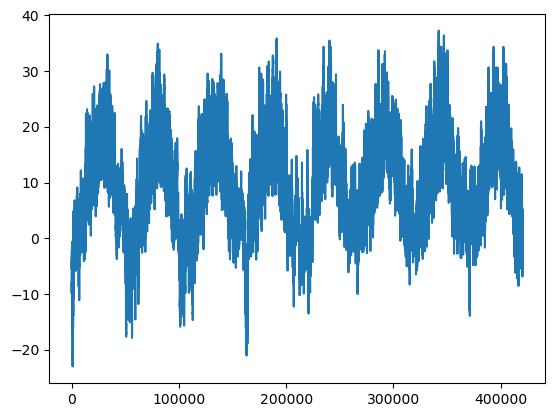

In [7]:
plt.plot(range(len(temperature)), temperature)

In [12]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples

In [14]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std


In [16]:
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)


In [18]:
for samples, targets in train_dataset:
        print("samples shape:", samples.shape)
        print("targets shape:", targets.shape)
        break

samples shape: (256, 120, 14)
targets shape: (256,)


In [20]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

In [22]:
callbacks = [
    keras.callbacks.ModelCheckpoint("temp_pred_lstm.keras", save_best_only=True)
]

model.compile(optimizer="adam", loss="mse", metrics=["mae"])

history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=val_dataset,
    callbacks=callbacks)


Epoch 1/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 38s 45ms/step - loss: 82.2326 - mae: 6.9699 - val_loss: 18.0408 - val_mae: 3.1547
Epoch 2/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 35s 43ms/step - loss: 16.7639 - mae: 3.0779 - val_loss: 11.4035 - val_mae: 2.5727
Epoch 3/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 35s 43ms/step - loss: 11.6947 - mae: 2.6454 - val_loss: 10.3014 - val_mae: 2.4868
Epoch 4/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 36s 44ms/step - loss: 10.7053 - mae: 2.5537 - val_loss: 9.7216 - val_mae: 2.4105
Epoch 5/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 36s 44ms/step - loss: 9.9765 - mae: 2.4711 - val_loss: 9.6264 - val_mae: 2.3981
Epoch 6/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 36s 44ms/step - loss: 9.4365 - mae: 2.4062 - val_loss: 9.4677 - val_mae: 2.3742
Epoch 7/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 36s 43ms/step - loss: 8.9774 - mae: 2.3461 - val_loss: 9.3905 - val_mae: 2.3636
Epoch 8/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 36s 44ms/step - loss: 8.5975 - mae: 2.2946 - val_loss: 9.3026 - val_mae: 2.3596
Epoch 9/10
819/819 ━━━━━━━━━━━━━━

In [24]:
model = keras.models.load_model("temp_pred_lstm.keras")
test_mae = model.evaluate(test_dataset)[1]
print(f"Test MAE: {test_mae:.2f}")

405/405 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 10.2999 - mae: 2.5447
Test MAE: 2.55


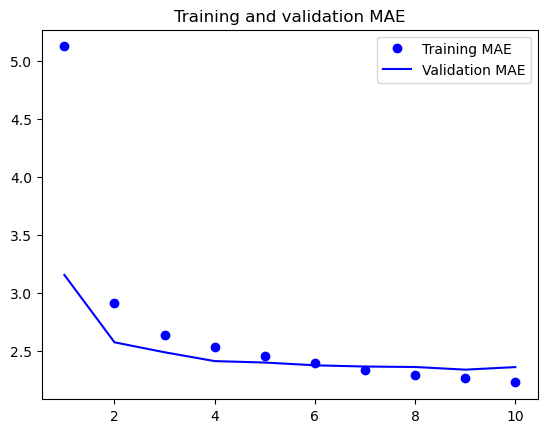

In [28]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()